# Main model characteristics 
- Data prepro: Normalization of datasets + hot encoding of labels (classes)
- Data augmentation: rotation, vert. & horiz. flips, brightness
- Model type: Inception 
  - Inception blocks: 2DConv_1x1, 2DConv_3x3, 2x2DConv_3x3, MaxPool+2DConv_3x3 with Leakyrelu activation & BN  
  - Reduction block:
  - Overall Model: Stem + 2stg inceptions + reduction + 5stg inceptions  
  - AveragePoolomg + softmax
  - loss="categorical_crossentropy", optimizer="adam", initial LR=0.0005


- Sequential runs with manually adjusted batch size and learning rates, see notes below
- Intermediate model trained on augmented data: filename = "cifar10-v3.2.tf"
- Final model trained on both augment and cifar-10 datasets: filename = "cifar10-v3.3.tf"
- Final validation accuracy: 92.1% ("cifar10-v3.3.tf" model)

In [1]:
# Case filename (used with Tensorborad and to save model)
filename = "cifar10-v4.3"

# Load notebook extension
%load_ext tensorboard

# Import required packages
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.initializers import GlorotUniform,  GlorotNormal, RandomNormal, RandomUniform, LecunNormal, LecunUniform, Constant
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from packaging import version

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


== Reading raw dataset ==
X_train_raw: (50000, 32, 32, 3)  as  uint8
y_train: (50000, 1)  as  uint8
X_test_raw:  (10000, 32, 32, 3)  as  uint8
y_test:  (10000, 1)  as  uint8


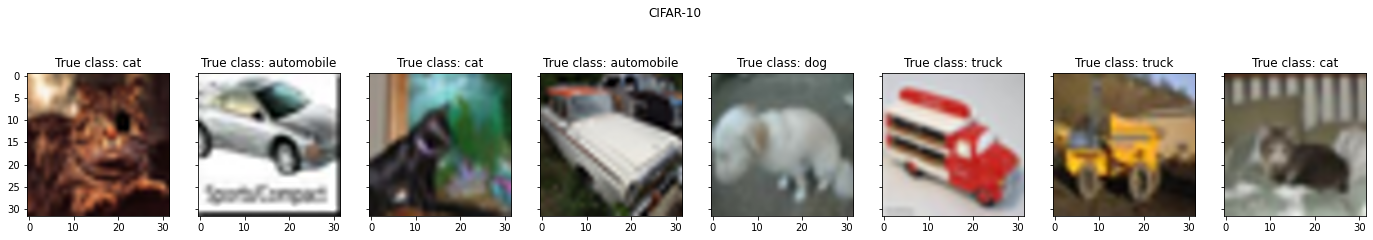

In [2]:
# Load CIFAR-10 dataset & check data dimension
# Ref: Homepage: https://www.cs.toronto.edu/~kriz/cifar.html

print('== Reading raw dataset ==')
(X_train_raw, y_train), (X_test_raw, y_test) = tf.keras.datasets.cifar10.load_data() 

print("X_train_raw:",X_train_raw.shape, " as ", X_train_raw.dtype)
print("y_train:",y_train.shape, " as ", y_train.dtype)
print("X_test_raw: ",X_test_raw.shape, " as ", X_test_raw.dtype)
print("y_test: ",y_test.shape, " as ", y_test.dtype)

# Set training and test datasets, define classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
N_classes = len(class_names)

# Plot a couple of pictures for fun
Npics=8
fig, ax = plt.subplots(nrows=1, ncols=Npics, figsize=(Npics*3,4), sharey=True)
fig.suptitle('CIFAR-10')
for i in range(Npics):
  rnd = np.random.randint(1000)
  ax[i].imshow(X_train_raw[rnd,:,:,:], interpolation='spline16')
  ax[i].set_title (str("True class: "+class_names[y_train[rnd][0]]))


In [3]:
### Normalization
print("== Normalized data shape ==")
X_train = X_train_raw.astype(np.float32) /255.0
X_test = X_test_raw.astype(np.float32) / 255.0

# OR

### Standardization over whole dataset but each RGB channel independently")

# print("== Standardized data shape ==")
# X_train_mean = np.mean(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train_std = np.std(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train = (X_train_raw.astype(np.float32) - X_train_mean) / X_train_std
# X_test = (X_test_raw.astype(np.float32) - X_train_mean) / X_train_std

print("X_train_raw:",X_train.shape, " as ", X_train.dtype)
print("X_test_raw: ",X_test.shape, " as ", X_train.dtype)
print()

print("== 1st image ==\n RGB channel average:",X_train[0,:,:,:].mean(axis=(0,1)))
print(" RGB channel min:",X_train[0,:,:,:].min(axis=(0,1)))
print(" RGB channel max:",X_train[0,:,:,:].max(axis=(0,1)))

== Normalized data shape ==
X_train_raw: (50000, 32, 32, 3)  as  float32
X_test_raw:  (10000, 32, 32, 3)  as  float32

== 1st image ==
 RGB channel average: [0.5537454  0.41215533 0.25112593]
 RGB channel min: [0. 0. 0.]
 RGB channel max: [1.         0.99215686 0.92156863]


In [4]:
# Hot encoding of labels (not strictly necessary, depends on selected loss function)
print ('== Hot encoding of labels ==')
y_train_cat = to_categorical (y_train).astype(np.uint8)
y_test_cat = to_categorical (y_test).astype(np.uint8)

print("y_train_cat:",y_train_cat.shape, " as ", y_train_cat.dtype)
print("y_test_cat: ",y_test_cat.shape, " as ", y_test_cat.dtype)

print('Example: ',y_train_cat[0])


== Hot encoding of labels ==
y_train_cat: (50000, 10)  as  uint8
y_test_cat:  (10000, 10)  as  uint8
Example:  [0 0 0 0 0 0 1 0 0 0]


== Image augmentation ==


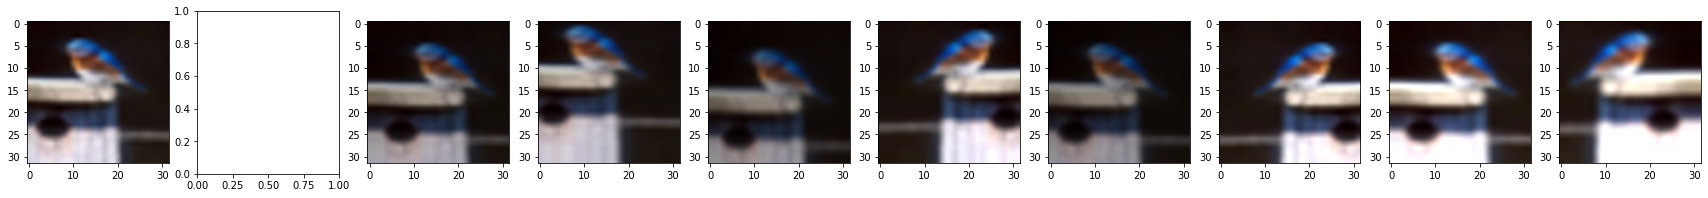

In [5]:
# Dataset augmentation 
print ('== Image augmentation ==')

def orthogonal_rot(image):
    """Randomly rotate an image by 90deg (clock or anticlock wise)
    Args:
        image ([numpy array]): Image
    Returns:
        [numpy array]: Rotated Image
    """
    return np.rot90(image, np.random.choice([-1, 0, 1],p=[0.25, 0.5, 0.25]))

datagen = ImageDataGenerator(
            rescale = 1./255,
            # featurewise_center=True, #### average done on whole dataset
            # featurewise_std_normalization=True,             
            # samplewise_center=True,  #### average done on each image
            # samplewise_std_normalization=True,    
            # zca_whitening=True, 
            # zca_epsilon=2, 
            # rotation_range=15,
            # zoom_range=[0.9, 1.1],
            width_shift_range=0.1,
            height_shift_range=0.1,
            fill_mode="nearest",
            # cval=0.0,
            # channel_shift_range=32, 
            # shear_range=15,
            brightness_range=[0.4,1.5],
            horizontal_flip=True, 
            # vertical_flip=True, 
            # preprocessing_function=orthogonal_rot, 
            # data_format='channels_last', 
            # validation_split=0.2, 
            # dtype='float32'
            )
datagen.fit(X_train_raw)  # only required if stats are required (ie using ZCA, feature/sample-wise augmentations)


def show_augmentation(datagen, X, n_pics=5):
    """"
    Synopsis: Randomly select an image from a dataset and plots a few augmented image variants 
              The first picture on the left is the original picture from cifar-10 dataset.
    Args: 
        datagen: ImageDataGenerator class
        X: image dataset as a 4d numpy tensor
        n_pics: number of augmented variants to display
        
        Output: None
    """
    rnd = np.random.randint(X.shape[0])
    img_iterator = datagen.flow(X[rnd].reshape(1, 32, 32, 3), batch_size=1)

    fig, ax = plt.subplots(nrows=1, ncols=n_pics+2, figsize=((n_pics+2)*3, 3))
    ax[0].imshow(X[rnd].reshape(32,32,3), interpolation='spline16') 
    # ax[1].axis('off')
    for i in range(n_pics):
        # ax[i+2].axis('off')
        img = img_iterator.next().reshape(32,32,3)
        # ax[i+2].imshow(img.astype('uint8')) ### use when no rescaling defined in ImageDataGenerator
        ax[i+2].imshow(img, interpolation='spline16') 

show_augmentation(datagen, X_train_raw[10:15], 8) # Must be passed dataset used during Generator fit 


In [6]:
# Some helper functions
 
def plot_evaluation (history_pd):
    """
    Synopsis: Plot loss and accuracy convergence histories for training and validation datasets 
    Args:
        history_pd: panda dataframe containg cvg history from the Keras model fit function
    Returns: None
    """
    Nfigs = int(len(history_pd.columns)/2)
    fig, ax = plt.subplots(nrows=1, ncols=Nfigs, figsize=(Nfigs*5,3))
    fig.suptitle('CIFAR-10 evaluation')

    for i in range(Nfigs):
        history_pd.iloc[:,i].plot(ax=ax[i], label='Training ') 
        history_pd.iloc[:,i+Nfigs].plot(ax=ax[i], label='Validation ')
        ax[i].set_title(history_pd.columns[i])
        ax[i].legend()
        ax[i].grid(True)
        ax[i].set_xlabel('epochs')

def lr_schedule(epoch, lr):
    """
    Synopsis: Learning rate callback function, reduces LR after a certain number of Epochs
    Args:
        epoch: current epoch
        lr: current learning rate
    Returns:
        [float]: updated learning rate
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.9


In [7]:
def inception_block(input_pipe, A_1x1_filters,B_1x1_filters, B_3x3_filters, 
                    C_1x1_filters, C1_3x3_filters, C2_3x3_filters, D_1x1_filters, 
                    myKinit, myBinit, myActivation, name=None, padding='same'):
      
    pipe_A = Conv2D(A_1x1_filters, (1, 1), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(input_pipe)
    pipe_A = BatchNormalization()(pipe_A)
    pipe_A = Activation(myActivation)(pipe_A)
    
    pipe_B = Conv2D(B_1x1_filters, (1, 1), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(input_pipe)
    pipe_B = BatchNormalization()(pipe_B)
    pipe_B = Activation(myActivation)(pipe_B)
    pipe_B = Conv2D(B_3x3_filters, (3, 3), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(pipe_B)
    pipe_B = BatchNormalization()(pipe_B)
    pipe_B = Activation(myActivation)(pipe_B)

    pipe_C = Conv2D(C_1x1_filters, (1, 1), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(input_pipe)
    pipe_C = BatchNormalization()(pipe_C)
    pipe_C = Activation(myActivation)(pipe_C)
    pipe_C = Conv2D(C1_3x3_filters, (3, 3), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(pipe_C)
    pipe_C = BatchNormalization()(pipe_C)
    pipe_C = Activation(myActivation)(pipe_C)
    pipe_C = Conv2D(C2_3x3_filters, (3, 3), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(pipe_C)
    pipe_C = BatchNormalization()(pipe_C)
    pipe_C = Activation(myActivation)(pipe_C)

    pipe_D = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding=padding)(input_pipe)
    pipe_D = Conv2D(D_1x1_filters, (1, 1), strides=(1, 1), padding=padding, activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(pipe_D)
    pipe_D = BatchNormalization()(pipe_D)
    pipe_D = Activation(myActivation)(pipe_D)

    output = concatenate([pipe_A, pipe_B, pipe_C, pipe_D], name=name)
    
    return output
    

In [8]:
def reduction_block(input_pipe, B_3x3_filters,myKinit, myBinit, myActivation, name=None):
    
    pipe_A = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(input_pipe)
    
    pipe_B = Conv2D(B_3x3_filters, (3, 3), strides=(2, 2), padding='same', activation=myActivation, kernel_initializer=myKinit, bias_initializer=myBinit)(input_pipe)
    pipe_B = BatchNormalization()(pipe_B)
    pipe_B = Activation(myActivation)(pipe_B)

    output = concatenate([pipe_A, pipe_B], name=name)
    
    return output

In [9]:
#### INITIALIZERS
myBiasInit = Constant(value=0.1)
# myBiasInit = GlorotUniform()
# myInitializer = GlorotUniform()
# myInitializer = LecunNormal()
# myInitializer = LecunUniform()
# myInitializer = RandomNormal()
myInitializer = GlorotNormal()

#### OPTIMIZERS
# lr_ExpDecay = ExponentialDecay(initial_learning_rate = 0.01, decay_steps = N_steps * 10, decay_rate = 0.85, staircase=True)
# myOptimizer = SGD(learning_rate=0.001)
# myOptimizer = SGD(learning_rate=lr_ExpDecay, decay=1e-6, momentum=0.9)  
# myOptimizer = SGD(learning_rate=lr_ExpDecay, decay=1e-6, momentum=0.9, nesterov=True)
# myOptimizer = RMSprop(learning_rate=0.01, decay=1e-06)
# myOptimizer = Adam(learning_rate=0.001, epsilon=1e-08)
myOptimizer = Adam(learning_rate=0.0005, epsilon=1e-08, amsgrad=True)

#### LOSSES
# myLoss = "sparse_categorical_crossentropy" 
myLoss = "categorical_crossentropy" 
# myLoss = "mse"

#### METRICS
myMetrics = ["accuracy"] #,Precision(name='precision'), Recall(name='recall')]

#### ACTIVATION
# myActivation = 'relu'
myActivation = LeakyReLU()

#### CALLBACKS
logdir = "logs/scalars/" + filename  # datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_CB = TensorBoard(log_dir=logdir, histogram_freq=1)
# early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=4)
# LR_scheduler = LearningRateScheduler(lr_schedule)
# RonP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
myCallbacks = [tensorboard_CB] 


# %tensorboard --logdir logs/scalars

In [12]:
### Build model

input_layer = Input(shape=(32, 32, 3))

# STEM 
pipe = Conv2D(96, (3, 3), padding='same', strides=(1, 1), name='stem_conv2D_3x3', kernel_initializer=myInitializer, bias_initializer=myBiasInit)(input_layer) 
pipe = BatchNormalization()(pipe)
pipe = Activation(myActivation)(pipe)

# Inception stage 1
pipe = inception_block(pipe, 24,  24,24,  24,24,24,  24, myInitializer, myBiasInit, myActivation, name='inception_stg1') # 32,32,96
# Inception stage 2
pipe = inception_block(pipe, 48, 32,32, 32,32,32, 24, myInitializer, myBiasInit, myActivation, name='inception_stg2')  # 32,32, 136
#_Reduction1
pipe = reduction_block(pipe, 76,myInitializer, myBiasInit, myActivation, name='Reduction1') # 16,16, 212

# Inception stage 3
pipe = inception_block(pipe, 96, 32,32, 24,24,24, 32, myInitializer, myBiasInit, myActivation, name='inception_stg3') # 16,16,184
# Inception stage 4
pipe = inception_block(pipe, 80, 48,48, 24,24,24, 24, myInitializer, myBiasInit, myActivation, name='inception_stg4') # 16,16,176
# Inception stage 5
pipe = inception_block(pipe, 64, 64,64, 24,24,24, 24, myInitializer, myBiasInit, myActivation, name='inception_stg5') # 16,16,176
# Inception stage 6
pipe = inception_block(pipe, 32, 80,80, 24,24,24, 24, myInitializer, myBiasInit, myActivation, name='inception_stg6') # 16,16,160
# Inception stage 7
pipe = inception_block(pipe, 96, 32,32, 24,24,24, 48, myInitializer, myBiasInit, myActivation, name='inception_stg7') # 16,16,200
#_Reduction2
pipe = reduction_block(pipe, 96, myInitializer, myBiasInit, myActivation, name='Reduction2') # 8,8,296

# Inception stage 8
pipe = inception_block(pipe, 152, 128,128, 64,64,64, 64, myInitializer, myBiasInit, myActivation, name='inception_stg8') # 8,8,408
# Inception stage 9
pipe = inception_block(pipe, 152, 128,128, 64,64,64, 64, myInitializer, myBiasInit, myActivation, name='inception_stg9') # 8,8,408


pipe= AveragePooling2D((5, 5))(pipe) # 1,1,408
pipe = Dropout(0.75)(pipe)

# Fully connected network
pipe = Flatten()(pipe) # 408
pipe = Dense(10, activation='softmax', name='softmax')(pipe) #10

model = Model(input_layer, pipe, name='inception_model1')

model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

##### MODEL overview
model.summary()
plot_model(model, to_file=filename+'.png', show_shapes=True, show_layer_names=True)


Model: "inception_model1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv2D_3x3 (Conv2D)        (None, 32, 32, 96)   2688        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 32, 32, 96)   384         stem_conv2D_3x3[0][0]            
__________________________________________________________________________________________________
activation_132 (Activation)     (None, 32, 32, 96)   0           batch_normalization_132[0][0]    
___________________________________________________________________________________

Running 100 Epochs (batch size 256) with 195steps/epoch
Epoch 1/100
195/195 [==============================] - 64s 245ms/step - loss: 1.9399 - accuracy: 0.3255 - val_loss: 3.4593 - val_accuracy: 0.0999
Epoch 2/100
195/195 [==============================] - 45s 223ms/step - loss: 1.1997 - accuracy: 0.5751 - val_loss: 2.6082 - val_accuracy: 0.2289
Epoch 3/100
195/195 [==============================] - 43s 221ms/step - loss: 0.9228 - accuracy: 0.6746 - val_loss: 1.1519 - val_accuracy: 0.5942
Epoch 4/100
195/195 [==============================] - 43s 221ms/step - loss: 0.7665 - accuracy: 0.7333 - val_loss: 0.9057 - val_accuracy: 0.6888
Epoch 5/100
195/195 [==============================] - 44s 224ms/step - loss: 0.6325 - accuracy: 0.7825 - val_loss: 0.8587 - val_accuracy: 0.7121
Epoch 6/100
195/195 [==============================] - 42s 216ms/step - loss: 0.5393 - accuracy: 0.8157 - val_loss: 0.7306 - val_accuracy: 0.7611
Epoch 7/100
195/195 [==============================] - 43s 223ms/ste

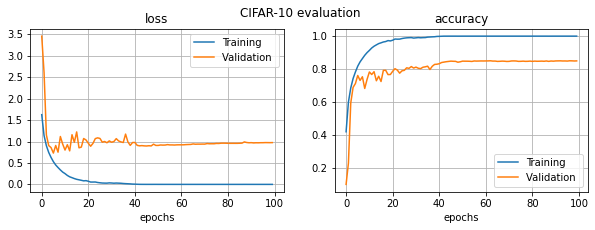

In [13]:
# RUN1 - Train on cifar-10 dataset
 
#### RUN PARAMETERS
batch_size = 256
N_epochs = 100
N_steps = X_train.shape[0] // batch_size

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

history = model.fit(
                    X_train, y_train_cat, 
                    # training_generator,
                    batch_size = batch_size,
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    shuffle=True, 
                    validation_data=(X_test, y_test_cat), 
                    # validation_data=validation_generator,
                    callbacks = myCallbacks,
                    verbose=1,
                    )

pd_history = pd.DataFrame(history.history) 
# pd_history_old = pd_history
# pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [14]:
model_filename = filename+"_run1.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run1.csv")

INFO:tensorflow:Assets written to: cifar10-v4.3_run1.tf\assets


INFO:tensorflow:Assets written to: cifar10-v4.3_run1.tf\assets


In [ ]:
# RUN2 - Train on augmented dataset
 
#### RUN PARAMETERS
batch_size = 128
N_epochs = 20
N_steps = X_train.shape[0] // batch_size
myOptimizer = Adam(learning_rate=0.0001, epsilon=1e-08, amsgrad=True)
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

history = model.fit(
                    # X_train, y_train_cat, 
                    training_generator,
                    batch_size = batch_size,
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    shuffle=True, 
                    # validation_data=(X_test, y_test_cat), 
                    validation_data=validation_generator,
                    callbacks = myCallbacks,
                    verbose=1,
                    )

# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [ ]:
model_filename = filename+"_run2.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run2.csv")

# NOTES:
changes & impact:
- 